<a href="https://colab.research.google.com/github/bartolomeoadrian/computer-vision/blob/main/08_fast_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Cargar librerías

In [32]:
import os
import math
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import requests
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.ops import box_iou
from PIL import Image, ImageDraw

# 2 - Cargar y normalizar imágenes

In [7]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

IMG_SIZE = 320
NUM_CLASSES = 2

def make_synthetic_image(num_objs_range=(1, 5)):
    """
    Create a synthetic road-like scene and draw rectangular 'vehicles'.
    Returns PIL image and a list of boxes [xmin,ymin,xmax,ymax].
    """
    W = H = IMG_SIZE

    img = Image.new("RGB", (W, H), (80, 80, 80))
    d = ImageDraw.Draw(img)

    lane_w = W // 6
    for k in range(1, 6, 2):
        x0 = k * lane_w
        d.rectangle([x0-2, 0, x0+2, H], fill=(100, 100, 100))

    n_objs = random.randint(*num_objs_range)
    boxes = []

    for _ in range(n_objs):
        bw = random.randint(24, 80)
        bh = random.randint(16, 60)

        xmin = random.randint(10, W - bw - 10)
        ymin = random.randint(40, H - bh - 10)
        xmax = xmin + bw
        ymax = ymin + bh

        color = tuple(int(x) for x in np.random.randint(120, 255, size=3))
        d.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)

        for inset in range(1, 3):
            d.rectangle([xmin+inset, ymin+inset, xmax-inset, ymax-inset], outline=color, width=1)

        boxes.append([xmin, ymin, xmax, ymax])

    return img, boxes

class TinyRoadVehicles(Dataset):
    """
    Synthetic detection dataset: one class 'vehicle' (label=1).
    """
    def __init__(self, n_images=500, transform=None, num_objs_range=(1, 5), cache=True):
        self.n_images = n_images
        self.transform = transform
        self.num_objs_range = num_objs_range
        self.cache = cache
        self._cache_imgs = []
        self._cache_targets = []
        if cache:
            for _ in range(n_images):
                img, boxes = make_synthetic_image(num_objs_range)
                target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32),
                    "labels": torch.ones((len(boxes),), dtype=torch.int64)
                }
                self._cache_imgs.append(img)
                self._cache_targets.append(target)

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        if self.cache:
            img = self._cache_imgs[idx]
            target = self._cache_targets[idx]
        else:
            img, boxes = make_synthetic_image(self.num_objs_range)
            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.ones((len(boxes),), dtype=torch.int64)
            }

        if self.transform is not None:
            img = self.transform(img)

        return img, target

train_tfms = T.Compose([
    T.ToTensor(),
])

test_tfms = T.Compose([
    T.ToTensor(),
])

dataset_train = TinyRoadVehicles(n_images=600, transform=train_tfms, num_objs_range=(2,6), cache=True)
dataset_test  = TinyRoadVehicles(n_images=120, transform=test_tfms,  num_objs_range=(1,4), cache=True)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True,  collate_fn=collate_fn, num_workers=0)
test_loader  = DataLoader(dataset_test,  batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0)

len(dataset_train), len(dataset_test)

(600, 120)

# 3 - Definir una red neuronal

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = ssdlite320_mobilenet_v3_large(weights=None, weights_backbone=None, num_classes=NUM_CLASSES)
model.to(device)

print("Model ready")

Model ready


# 4 - Definir una función de pérdida y un optimizador

In [13]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.02, momentum=0.9, weight_decay=5e-4)

# 5 - Entrenar a la red

In [14]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running = 0.0
    for i, (images, targets) in enumerate(train_loader):
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()
        if i % 20 == 0:
            print(f"[Epoch {epoch}] Iter {i:03d}  Loss: {loss.item():.4f}")
    print(f"Epoch {epoch} avg loss: {running/(i+1):.4f}")

[Epoch 0] Iter 000  Loss: 10.7647
[Epoch 0] Iter 020  Loss: 5.6938
[Epoch 0] Iter 040  Loss: 3.6082
[Epoch 0] Iter 060  Loss: 2.6393
Epoch 0 avg loss: 4.7063
[Epoch 1] Iter 000  Loss: 2.1195
[Epoch 1] Iter 020  Loss: 1.7048
[Epoch 1] Iter 040  Loss: 2.3769
[Epoch 1] Iter 060  Loss: 1.9854
Epoch 1 avg loss: 2.0823
[Epoch 2] Iter 000  Loss: 2.0119
[Epoch 2] Iter 020  Loss: 1.4674
[Epoch 2] Iter 040  Loss: 1.7815
[Epoch 2] Iter 060  Loss: 1.7037
Epoch 2 avg loss: 1.6638
[Epoch 3] Iter 000  Loss: 1.4401
[Epoch 3] Iter 020  Loss: 1.7776
[Epoch 3] Iter 040  Loss: 1.6988
[Epoch 3] Iter 060  Loss: 1.1560
Epoch 3 avg loss: 1.5361
[Epoch 4] Iter 000  Loss: 1.5121
[Epoch 4] Iter 020  Loss: 1.7916
[Epoch 4] Iter 040  Loss: 1.6308
[Epoch 4] Iter 060  Loss: 1.5005
Epoch 4 avg loss: 1.3667


# 6 - Prueba de la red

In [15]:
model.eval()
score_thresh = 0.5
iou_thresh   = 0.5

total_pred = 0
total_gt   = 0
total_correct = 0

with torch.no_grad():
    for images, targets in test_loader:
        img = images[0].to(device)
        target = {k: v.to(device) for k, v in targets[0].items()}

        out = model([img])[0]
        keep = out["scores"].cpu() >= score_thresh
        pred_boxes = out["boxes"][keep].cpu()

        gt_boxes = target["boxes"].cpu()

        total_pred += len(pred_boxes)
        total_gt   += len(gt_boxes)

        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        correct = (ious >= iou_thresh).any(dim=1).sum().item()
        total_correct += correct

precision = total_correct / total_pred if total_pred else 0.0
recall    = total_correct / total_gt   if total_gt   else 0.0

print(f"Score threshold: {score_thresh} | IoU threshold: {iou_thresh}")
print(f"GT boxes: {total_gt} | Predicted boxes: {total_pred} | Correct: {total_correct}")
print(f"Precision: {precision:.3f} | Recall: {recall:.3f}")

Score threshold: 0.5 | IoU threshold: 0.5
GT boxes: 310 | Predicted boxes: 165 | Correct: 164
Precision: 0.994 | Recall: 0.529


# 7 - Predicción

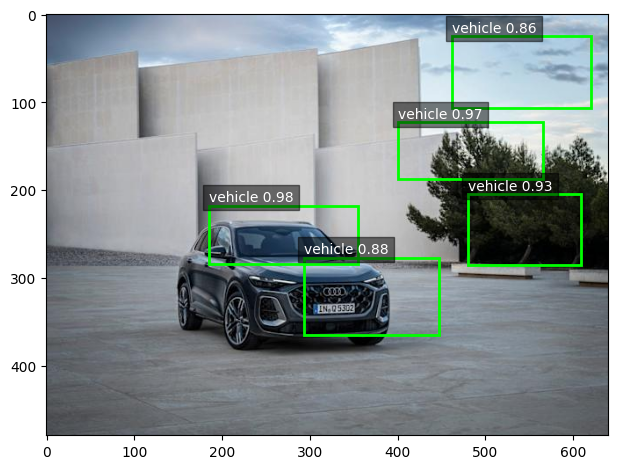

In [31]:
image_url = 'https://raw.githubusercontent.com/bartolomeoadrian/computational-vision/refs/heads/main/assets/images/car_2.jpg'
resp = requests.get(image_url, timeout=30)
with open('car.jpg', 'wb') as f:
    f.write(resp.content)

img_bgr = cv2.imread('car.jpg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

model.eval()
with torch.no_grad():
    out = model([img_tensor.to(device)])[0]

plt.imshow(img_rgb)

score_thresh_vis = 0.8
keep = out["scores"].detach().cpu() >= score_thresh_vis
boxes  = out["boxes"][keep].detach().cpu().int().tolist()
scores = out["scores"][keep].detach().cpu().tolist()

for (xmin, ymin, xmax, ymax), sc in zip(boxes, scores):
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        edgecolor='lime', facecolor='none', linewidth=2
    ))
    plt.text(xmin, max(ymin - 5, 0), f"vehicle {sc:.2f}",
             fontsize=10, color='white',
             bbox=dict(facecolor='black', alpha=0.5))

plt.tight_layout()
plt.show()